# 第13章 LQG制御への応用

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

#### 乱数シードの指定（テキスト掲載用）
拙著に掲載の標本路を再現するため，シードを明示しておきます．本来は必要ないので，コメントアウトしてもいいです．

In [2]:
np.random.seed(123)

## クラスと関数

### 算法12.2 （Kalman-Bucyフィルタ）

In [3]:
from class_ssKBF import * #実行フォルダに class_ssKBF.py を置いてインポートします．
#for line in open('./class_ssKBF.py'): print(line[:-1]) #内容の確認 

### 標本路の取得（線形一般，連続時間）

In [4]:
from class_LinearSDE import * #実行フォルダに class_LinearSDE.py を置いて(class_SDE.pyも置く)インポートします．
#for line in open('./class_LinearSDE.py'): print(line[:-1]) #内容の確認 

## 12.4 数値例

In [5]:
class mech_1dof_control: #1自由度機械振動系の制御
    
    def __init__(self, c=0.2, k=5, Δt=0.02, Qval=0, Rval=0.01 ):
        ### システムの定義
        # 状態行列
        self.A = np.array([[0,1],[-k,-c]])
        # 入力行列
        self.B = np.array([[0],[1]]) 
        # 駆動行列
        self.D = np.array([[0],[1]]) 
        # 観測行列：1行2列と仮定
        self.C = np.array([[1,0]])
        # ノイズの条件
        self.Q = np.array([[Qval]])
        self.R = np.array([[Rval]])
        ### 出力データ
        self.tt = None   # 時刻の列
        self.xx = None   # 状態量の時系列
        self.yy = None   # 観測量の時系列
        self.xxf = None  # 濾波推定値の時系列
        self.xxni = None # 数値積分推定値の時系列
        ### その他
        self.Δt = Δt   # 数値積分の時間ステップ
        
    ### 標本路の取得
    def get_sample_free(s, x0=[1,0], tn=200):
        # 初期値とデータ長
        s.x0 = np.array(x0)
        s.tn = tn
        sde = class_LinearSDE(s.A, s.D, s.C, s.Q, s.R, s.x0, s.Δt)
        s.tt = np.zeros(tn+1)   #時刻の列
        s.xx = np.zeros((tn+1, s.A.shape[0]))  #状態ベクトルの時系列
        s.yy = np.zeros((tn+1, s.C.shape[0])) #観測ベクトルの時系列

        for i in range(tn+1):
            s.tt[i] = sde.t
            s.xx[i,:] = sde.x
            s.yy[i] = sde.get_output()
            sde.solve()
            
        s.yy_clean = np.array([s.C.dot(xx) for xx in s.xx])

    def get_sample_NDctrl(s, gain, x0=[1,0], tn=200, is_ND=True):
        # 初期値とデータ長
        s.x0 = np.array(x0)
        s.tn = tn
        sde = class_LinearSDE(s.A, s.D, s.C, s.Q, s.R, s.x0, s.Δt, B=s.B)
        s.tt = np.zeros(tn+1)   #時刻の列
        s.xx = np.zeros((tn+1, s.A.shape[0]))  #状態ベクトルの時系列
        s.yy = np.zeros((tn+1, s.C.shape[0])) #観測ベクトルの時系列

        for i in range(tn+1):

            s.tt[i] = sde.t
            s.xx[i,:] = sde.x
            s.yy[i] = sde.get_output()

            if is_ND:
                if i==0:
                    dyND = 0
                else:
                    dyND = s.ND(s.yy[i],s.yy[i-1])
            else:
                dyND = sde.x[1]
            
            u = -gain*dyND #数値微分推定値による速度フィードバック
            sde.set_input(u)
            sde.solve()
        
        s.yy_clean = np.array([s.C.dot(xx) for xx in s.xx])
        
    def get_sample_LQG(s, feedback_gain, x0=[1,0], tn=200, is_LQG=True):
        # 初期値とデータ長
        s.x0 = np.array(x0)
        s.tn = tn
        sde = class_LinearSDE(s.A, s.D, s.C, s.Q, s.R, s.x0, s.Δt, B=s.B)
        s.tt = np.zeros(tn+1)   #時刻の列
        s.xx = np.zeros((tn+1, s.A.shape[0]))  #状態ベクトルの時系列
        s.yy = np.zeros((tn+1, s.C.shape[0])) #観測ベクトルの時系列

        x0 = s.x0
        cov0 = np.zeros((2,2))

        F = np.array(feedback_gain)
        CL = s.A - np.outer(s.B, F)
        kbf = class_ssKBF(s.A, s.D, s.C, s.Q, s.R, x0, cov0, CL=CL)

        for i in range(tn+1):

            s.tt[i] = sde.t
            s.xx[i,:] = sde.x
            s.yy[i] = sde.get_output()

            kbf.filtering(s.yy[i],s.Δt)

            if is_LQG:
                u = -F.dot(kbf.xf)
            else:
                u = -F.dot(sde.x)

            sde.set_input(u)
            sde.solve()
        
        
    ### 濾波推定
    def do_filtering(s):
        x0 = s.x0
        cov0 = np.zeros((2,2))
        kbf = KalmanBucyFilter(s.A, s.D, s.C, s.Q, s.R, x0, cov0)
        s.xxf = np.zeros((s.tn+1,2))
        for t, yt in enumerate(s.yy):
            s.xxf[t,:] = kbf.xf
            kbf.filtering(yt,s.Δt)

    ### 数値微分による推定
    def ND(self, y_now, y_prev):
        return (y_now - y_prev)/self.Δt
    
    def NDs(self, yy):
        dyND = np.zeros_like(yy)
        dyND[0] = 0 #初期値には過去がないので，便宜上0としてみる
        dyND[1:] = self.ND(yy[1:], yy[:-1])
        return dyND
    
    ### 結果のプロット
    def init_plot(self):
        self.fig, self.ax = plt.subplots(2, 1, figsize=(5, 3), sharex=True)
        self.fig.subplots_adjust(left=0.1, right=0.95, top=0.95)
        self.ax[1].set_xlabel('$t$',fontsize=12)
        self.ax[0].set_xlim([self.tt.min(),self.tt.max()])
        sublabels=['(a)','(b)']
        for i, ax in enumerate(self.ax):
            ax_pos = ax.get_position()
            self.fig.text(1.01*ax_pos.x1, -0.02+0.975*ax_pos.y1, sublabels[i], fontsize=12)

    def plot_free(self, tn):
        self.get_sample_free(tn=tn)
        self.init_plot()
        self.ax[0].plot(self.tt, self.yy_clean, '--', color='gray',  linewidth=2.0, label='$y=x$ (noiseless)')
        self.ax[1].plot(self.tt, self.yy,       '-', color='black', linewidth=0.8, label='$y=x+v$ (noisy)')
        for a in self.ax:
            a.legend()
        self.fig.text(0.0, 0.5, '$y$', va='center', rotation='vertical', fontsize=12)

    def plot_ND(self, tn):
        self.get_sample_free(tn=tn)
        self.init_plot()
        dyND_clean = self.NDs(self.yy_clean)
        dyND_noisy = self.NDs(self.yy)
        self.ax[0].plot(self.tt, self.xx[:,1], '--', color='gray', linewidth=2.0, label='$dx/dt$ (exact)')
        self.ax[0].plot(self.tt, dyND_clean,   '-', color='black',linewidth=0.8, label='$\Delta y/\Delta t$ of $y=x$ (noiseless)')
        self.ax[1].plot(self.tt, self.xx[:,1], '--', color='gray', linewidth=2.0, label='$dx/dt$ (exact)')
        self.ax[1].plot(self.tt, dyND_noisy,   '-', color='black',linewidth=0.1, label='$\Delta y/\Delta t$ of $y=x+v$ (noisy)')

        for a in self.ax:
            a.legend(loc='upper right')

        self.ax[1].set_ylim([-3,3])
        self.fig.text(0.0, 0.5, 'Estimated velocity', va='center', rotation='vertical', fontsize=12)

    def plot_NDctrl(self, tn, gain):
        self.get_sample_NDctrl(tn=tn, gain=gain, is_ND=False)
        self.init_plot()
        self.ax[0].plot(self.tt, self.xx[:,0], '--', color='gray',  linewidth=2.0, label='noiseless')
        self.ax[1].plot(self.tt, self.xx[:,1], '--', color='gray',  linewidth=2.0, label='noiseless')
        
        self.get_sample_NDctrl(tn=tn, gain=gain, is_ND=True)
        self.ax[0].plot(self.tt, self.xx[:,0], '-', color='black', linewidth=0.5, label='noisy')
        self.ax[1].plot(self.tt, self.xx[:,1], '-', color='black', linewidth=0.3, label='noisy')

        for a in self.ax:
            a.legend(loc='upper right')

        self.ax[0].set_ylabel('Displacement', fontsize=12)
        self.ax[1].set_ylabel('Velocity', fontsize=12)
        self.ax[1].set_ylim([-3,3])

    def plot_LQG(self, tn, gain):
        self.get_sample_LQG(tn=tn, feedback_gain=gain, is_LQG=False)
        self.init_plot()
        self.ax[0].plot(self.tt, self.xx[:,0], '--', color='gray', linewidth=2.0, label='noiseless')
        self.ax[1].plot(self.tt, self.xx[:,1], '--', color='gray', linewidth=2.0, label='noiseless')
        
        self.get_sample_LQG(tn=tn, feedback_gain=gain, is_LQG=True)
        self.ax[0].plot(self.tt, self.xx[:,0], '-', color='black', linewidth=0.5, label='noisy')
        self.ax[1].plot(self.tt, self.xx[:,1], '-', color='black', linewidth=0.5, label='noisy')

        for a in self.ax:
            a.legend()

        self.ax[0].set_ylabel('Displacement', fontsize=12)
        self.ax[1].set_ylabel('Velocity', fontsize=12)
        self.ax[1].set_ylim([-3,3])
        
    def save(s, filename):
        plt.savefig(filename, bbox_inches="tight")


### 標本路の確認

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


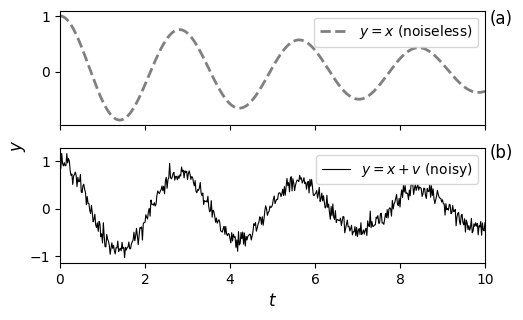

In [6]:
chapter1 = mech_1dof_control(Qval=0, Rval=0.01)
chapter1.plot_free(tn=500)
chapter1.save('figs/Ch13-outputs.eps')

### 数値微分による推定結果

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


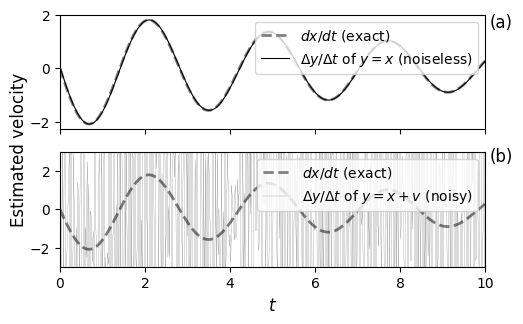

In [7]:
chapter1 = mech_1dof_control(Qval=0, Rval=0.01)
chapter1.plot_ND(tn=500)
chapter1.save('figs/Ch13-NDE.eps')

### 数値微分による速度フィードバック制御

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


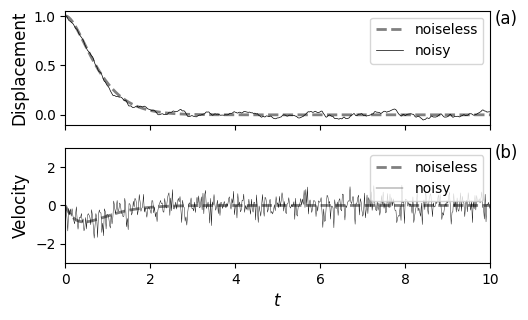

In [8]:
chapter1 = mech_1dof_control(Qval=0, Rval=0.01)
chapter1.plot_NDctrl(tn=500,gain=4)
chapter1.save('figs/Ch13-NDC.eps')

### Kalman-Bucyフィルタによる速度フィードバック制御

Steady-state Kalman gain =
 [[0.]
 [0.]]
Steady-state Kalman gain =
 [[0.]
 [0.]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


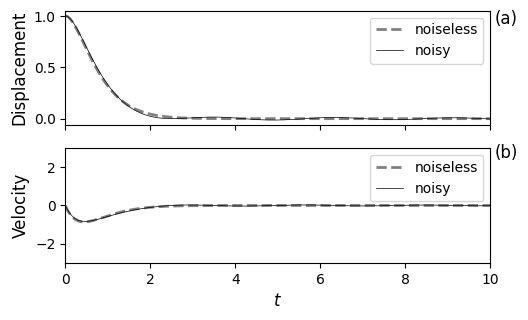

In [9]:
chapter1 = mech_1dof_control(Qval=0, Rval=0.01)
chapter1.plot_LQG(tn=500,gain=[0,4])
chapter1.save('figs/Ch13-LQG.eps')